# AGN use case notebook

**WARNING**: This notebook will be replaced by a version using the new database, API and client.

ALeRCE starter notebook for AGN science.
You will need to install psycopg2 and GPy

See https://alerceapi.readthedocs.io/en/latest/ for the ALeRCE API documentation.
See https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html for the schema of the alerts sent by ZTF.

### Load libraries
_External dependencies:_  
psycopg2: pip install psycopg2-binary  
GPy: pip install GPy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from scipy.stats import chi2
import sys

In [2]:
#!pip install psycopg2-binary
import psycopg2

In [3]:
#!pip install GPy
import GPy

In [4]:
import requests
from pandas.io.json import json_normalize

  
### Get credentials (not in github repository)  

In [5]:
import json
credentials_file = "../alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

  
### Connect to DB    

In [6]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

### Show all the available tables

In [7]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables

,tablename
0,late_probabilities_v3
1,insert_tmp
2,features_v3
3,objects
4,detections
5,late_probabilities_v2
6,taxonomy
7,tax_class
8,temp_probs
9,asassn


### For each table, show column names and column types

In [8]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


### Query class numbers

In [9]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'Blazar': 8,
 'CV/Nova': 9,
 'SLSN': 14,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22,
 'SNIa': 10,
 'SNIbc': 11,
 'SNII': 12,
 'SNIIn': 13,
 'EBSD/D': 15,
 'EBC': 16,
 'Periodic-Other': 17,
 'AGN-I': 7,
 'RS-CVn': 23,
 'QSO-I': 24}

  
### Create function to plot AGN light curve  

In [10]:
def plotLC(oid, AGN_det, AGN_nondet):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = AGN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(AGN_det[mask].mjd, AGN_det[mask].magpsf_corr, 
                yerr = AGN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        mask = (AGN_nondet.fid == fid) & (AGN_nondet.diffmaglim > -900)
        #if np.sum(mask) > 0:            
        #    ax.scatter(AGN_nondet[mask].mjd, AGN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
        #        marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

  
### Create function to get data and plot AGN light curve

In [11]:
def getAGNdata(oid, doplot = False):
    
    # query detections
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    AGN_det = pd.read_sql_query(query, conn)
    AGN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    AGN_nondet = pd.read_sql_query(query, conn)
    AGN_nondet.sort_values(by=['mjd'], inplace=True)
            
    if doplot:
        plotLC(oid, AGN_det, AGN_nondet)
                
    # return data
    return AGN_det, AGN_nondet

### Define some variability features  

(Sanchez-Saez et al 18, 19)


The probability that the source is intrinsically variable ($P_{var}$):  

$$\chi^2=\sum_{i=1}^{N_{obs}}\frac{(x_i-\bar{x})^2}{\sigma^2_{err,i}}$$
$$P_{var}=P(\chi^2)$$ 
  
And the excess variance ($\sigma_{rms}$), which a measure of the intrinsic variability amplitude:  

$$\sigma^2_{rms}=\frac{1}{N_{obs}\bar{x}^2}\sum^{N_{obs}}_{i=1}[(x_i-\bar{x})^2-\sigma^2_{err,i}]$$

In [12]:
def var_parameters(jd,mag,err):
    """function to calculate the probability of a light curve to be variable and the excess variance"""
    
    from scipy.stats import chi2
    
    mean = np.mean(mag)
    nepochs = float(len(jd))

    #P_var
    chi = np.sum( (mag - mean)**2. / err**2. )
    P_var = chi2.cdf(chi,(nepochs-1))

    #ex_var
    a = (mag - mean)**2
    ex_var = (np.sum(a - err**2)/((nepochs * mean**2)))
    

    return [P_var,ex_var]


Damped Random Walk process (DRW):  

$$dX(t)=-\frac{1}{\tau}X(t)dt+\sigma_{DRW}\sqrt{dt}\,\epsilon(t)+b\,dt$$
  
with $\tau,\sigma_{DRW},t>0$. $\tau$ corresponds to the "relaxation time" of the process or the characteristic time for the time series to become roughly uncorrelated, and has units of days, $\sigma_{DRW}$ corresponds to the amplitude of the variability at short time-scales ($t<<\tau$), and has units of mag/day$^{1/2}$

In [13]:
def GP_DRW(t, mag, err):
    """
    Based on Matthew Graham's method to model DRW with gaussian process

    inputs:
    t: julian days array
    mag: magnitudes array
    err: error of magnitudes array

    outputs:
    sigma^2: variance of the light curve at short time scales
    tau: decorrelation time scale
    """

    # Fit GP OU model
    mag -= mag.mean()
    kern = GPy.kern.OU(1)
    m = GPy.models.GPHeteroscedasticRegression(t[:, None], mag[:, None], kern)
    m['.*het_Gauss.variance'] = abs(err ** 2.)[:, None] 
    m.het_Gauss.variance.fix() 
    m.optimize()
    pars = [m.OU.variance.values[0], m.OU.lengthscale.values[0]] # sigma^2, tau
    return pars[0], pars[1]

  
### Load external dataframe with known changing state AGNs  (CSAGNs)
From multiple refences (e.g., Graham et al. 2019; MacLeod et al. 2016)

In [14]:
# read csv
mycatdf = pd.read_csv("../example_data/CSAGN_coordinates.csv")
mycatdf.head()

# rename some columns to be compatible with xmatch service
mycatdf.rename({"RA": "ra", "DEC": "dec"}, axis="columns", inplace=True)
mycatdf.index.names=["mycat_id"]

# drop nans in ra, dec
mycatdf.dropna(subset=['ra', 'dec'], inplace=True)
print(mycatdf.shape)
mycatdf.head()

(36, 2)


,ra,dec
mycat_id,,
0,123.330417,46.146944
1,144.551250,7.727778
2,150.583750,45.157500
3,173.121250,3.958056
4,194.819583,55.251944


### Use xmatch API to find ZTF cross matches

In [15]:
# format input data as json and use search radius of 1"
data = list(mycatdf.apply(lambda row: {"id": str(row.name), "ra": float(row.ra), "dec": float(row.dec)}, axis=1).values)
params = {"data": data, "sr": 1}
url = "https://xmatch-api.alerce.online/"
r = requests.post(url = "%s/xmatch" % url, json = params)
print(r.json()["status"])

SUCCESS


### Get data frame from output json

In [16]:
mycat_ztf = json_normalize(r.json()["xmatches"])
# note that there is one object with two crossmatches, you may want to select the nearest source
mycat_ztf.shape

(37, 49)

In [17]:
print(list(mycat_ztf))
mycat_ztf.head()

['ALeRCE_permalink', 'catalogid', 'classearly', 'classrf', 'classxmatch', 'dec', 'deltajd', 'distance_arcsec', 'first_magap_g', 'first_magap_r', 'first_magpsf_g', 'first_magpsf_r', 'firstmjd', 'id', 'last_magap_g', 'last_magap_r', 'last_magpsf_g', 'last_magpsf_r', 'lastmjd', 'max_magap_g', 'max_magap_r', 'max_magpsf_g', 'max_magpsf_r', 'mean_magap_g', 'mean_magap_r', 'mean_magpsf_g', 'mean_magpsf_r', 'meandec', 'meanra', 'median_magap_g', 'median_magap_r', 'median_magpsf_g', 'median_magpsf_r', 'min_magap_g', 'min_magap_r', 'min_magpsf_g', 'min_magpsf_r', 'nobs', 'oid', 'pclassearly', 'pclassrf', 'period', 'ra', 'sigma_magap_g', 'sigma_magap_r', 'sigma_magpsf_g', 'sigma_magpsf_r', 'sigmadec', 'sigmara']


,ALeRCE_permalink,catalogid,classearly,classrf,classxmatch,dec,deltajd,distance_arcsec,first_magap_g,first_magap_r,...,pclassearly,pclassrf,period,ra,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
0,http://alerce.online/object/ZTF18abtnfmp,None,None,None,None,46.146944,620.720463,0.832543,20.189100,18.428801,...,0.653095,0.203688,None,123.330417,0.395318,0.345452,0.362088,0.337519,0.000046,0.000074
1,http://alerce.online/object/ZTF19aaipqls,None,None,None,None,7.727778,431.999931,0.388108,19.256800,18.398899,...,0.999992,0.223892,None,144.551250,0.531601,0.431841,0.468508,0.352490,0.000062,0.000053
2,http://alerce.online/object/ZTF18acvgore,None,None,None,None,45.157500,497.738970,0.932801,20.432100,20.520599,...,0.563436,0.460416,None,150.583750,0.291703,0.266686,0.132903,0.091244,0.000059,0.000078
3,http://alerce.online/object/ZTF19aanhosb,None,None,None,None,3.958056,64.946493,0.505191,19.498899,19.860800,...,NaN,0.299520,None,173.121250,0.255449,0.146073,0.162353,0.100391,0.000051,0.000044
4,http://alerce.online/object/ZTF18acvgwug,None,None,None,None,55.251944,119.766019,0.519167,20.054899,NaN,...,NaN,NaN,None,194.819583,0.075943,NaN,0.194430,NaN,0.000047,0.000072


### Get the light curves of the crossmatched sources, plot them, and compute some variability features
Selectig only those sources with z<0.2 and with more than 50 detections in ZTF

['ZTF18abtnfmp' 'ZTF19aaipqls' 'ZTF18acvgore' 'ZTF19aanhosb'
 'ZTF18acvgwug' 'ZTF18aaoudgg' 'ZTF18abjyivn' 'ZTF18aauoxde'
 'ZTF19aascufy' 'ZTF18aawvzwe' 'ZTF18aagenpf' 'ZTF18aaeixri'
 'ZTF18aachhwp' 'ZTF18aactknu' 'ZTF18aaceswp' 'ZTF18aacozge'
 'ZTF18aajncmt' 'ZTF18aacekzd' 'ZTF18acbwaas' 'ZTF18aasrupq'
 'ZTF18aawpgrb' 'ZTF18aajkcve' 'ZTF18aayiule' 'ZTF18acepfmo'
 'ZTF19aalmwdr' 'ZTF18aaqdmoa' 'ZTF18aaxlxtr' 'ZTF18acezagf'
 'ZTF18aabpiat' 'ZTF18aaqmmll' 'ZTF18aanbpfo' 'ZTF19aamraau'
 'ZTF18aamznms' 'ZTF18aavohdq' 'ZTF20aalytmd' 'ZTF19acgpwkz'
 'ZTF18aajdcdt'] 

ZTF18abtnfmp  Pvar_g, exvar_g =  1.0 0.00026616986160329405
ZTF18abtnfmp  sigma_g, tau_g =  0.10831588438626448 10.395181961454405
ZTF18abtnfmp  Pvar_r, exvar_r =  1.0 0.00030880239890894017
ZTF18abtnfmp  sigma_r, tau_r =  0.14210017426905958 82.55152721139899
ZTF19aaipqls  Pvar_g, exvar_g =  1.0 0.0005840466199791237
ZTF19aaipqls  sigma_g, tau_g =  0.21215854123516878 13.058621356605938
ZTF19aaipqls  Pvar_r, exvar_r =  1.0 0.00

 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aawpgrb  Pvar_g, exvar_g =  1.0 5.5627752475603394e-05
ZTF18aawpgrb  sigma_g, tau_g =  0.03349480614316589 170.2291704924384
ZTF18aawpgrb  Pvar_r, exvar_r =  1.0 3.10488902179757e-05
ZTF18aawpgrb  sigma_r, tau_r =  0.026828341863541688 163.30066369660682


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aayiule  Pvar_g, exvar_g =  1.0 6.049192655453106e-05
ZTF18aayiule  sigma_g, tau_g =  0.15823589359400309 2482.271640204521
ZTF18aayiule  Pvar_r, exvar_r =  1.0 5.944793018098038e-05
ZTF18aayiule  sigma_r, tau_r =  0.007920761859958315 83.97527544063533


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18acepfmo  Pvar_g, exvar_g =  0.4514972880865616 -2.6079916260276627e-05
ZTF18acepfmo  sigma_g, tau_g =  0.006346312348104224 235.6557005897592


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF19aalmwdr  Pvar_g, exvar_g =  1.0 0.00030394892075420586
ZTF19aalmwdr  sigma_g, tau_g =  0.1304175952968019 1227.4849406510616
ZTF19aalmwdr  Pvar_r, exvar_r =  1.0 0.00018284461054348167
ZTF19aalmwdr  sigma_r, tau_r =  0.09103526730555132 1130.7566349236617


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aaqdmoa  Pvar_g, exvar_g =  0.9999708945803466 7.06680265919207e-06
ZTF18aaqdmoa  sigma_g, tau_g =  0.001874850634663407 22.026367832908125


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aaxlxtr  Pvar_g, exvar_g =  0.9999945435280628 2.2358303190203302e-05
ZTF18aaxlxtr  sigma_g, tau_g =  0.014493493066367262 74.3772382286395
ZTF18aaxlxtr  Pvar_r, exvar_r =  0.9999704905453348 9.791855966609676e-06
ZTF18aaxlxtr  sigma_r, tau_r =  0.004750014469904202 50.12757608514924


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18acezagf  Pvar_g, exvar_g =  0.18730831861066594 -7.376964379845294e-06
ZTF18acezagf  sigma_g, tau_g =  2.7221724745094705e-18 0.8952956553896387


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aabpiat  Pvar_g, exvar_g =  1.0 0.0005686495754645717
ZTF18aabpiat  sigma_g, tau_g =  0.3940181052470508 101.54064971018136
ZTF18aabpiat  Pvar_r, exvar_r =  1.0 0.0006376873281568958
ZTF18aabpiat  sigma_r, tau_r =  0.3878990549819465 141.4358846988771


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aaqmmll  Pvar_g, exvar_g =  1.0 0.0006403319244500709
ZTF18aaqmmll  sigma_g, tau_g =  0.453261498842358 4139.3895646591645
ZTF18aaqmmll  Pvar_r, exvar_r =  1.0 0.0004471853785700687
ZTF18aaqmmll  sigma_r, tau_r =  0.28380442970615016 4006.139878650616


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF19aamraau  Pvar_g, exvar_g =  0.02207217715682511 -0.00017386510603317862
ZTF19aamraau  sigma_g, tau_g =  0.01794425053319591 300.125496684115
ZTF19aamraau  Pvar_r, exvar_r =  0.01857361530185169 -6.394612401233072e-05
ZTF19aamraau  sigma_r, tau_r =  4.0168778890758994e-08 1.54385909338327


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aamznms  Pvar_g, exvar_g =  1.0 3.9827832817945855e-05
ZTF18aamznms  sigma_g, tau_g =  0.02301210991821232 410.5546408799468
ZTF18aamznms  Pvar_r, exvar_r =  1.0 2.5161454031811678e-05
ZTF18aamznms  sigma_r, tau_r =  0.01035710450329887 349.8813210481503


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aavohdq  Pvar_g, exvar_g =  1.0 0.0002922036804075974
ZTF18aavohdq  sigma_g, tau_g =  0.13121043392636086 64.80512142882033
ZTF18aavohdq  Pvar_r, exvar_r =  1.0 0.00017572853116740858
ZTF18aavohdq  sigma_r, tau_r =  0.0740813122095133 64.26601145952915


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF20aalytmd  Pvar_g, exvar_g =  1.0 0.000355004102016053
ZTF20aalytmd  sigma_g, tau_g =  0.19187706490930084 47.33118328625281
ZTF20aalytmd  Pvar_r, exvar_r =  1.0 0.0005787622999487027
ZTF20aalytmd  sigma_r, tau_r =  0.18402694501913736 71.48362344448034


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF19acgpwkz  Pvar_r, exvar_r =  0.6729415520096756 1.9614041387356536e-06
ZTF19acgpwkz  sigma_r, tau_r =  0.0016801476127104075 9.667844353215449


 /home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18aajdcdt  Pvar_g, exvar_g =  0.043468231554756855 -1.1112356954851395e-05
ZTF18aajdcdt  sigma_g, tau_g =  2.5381809172549346e-18 0.8014676103558729
ZTF18aajdcdt  Pvar_r, exvar_r =  0.022657712385671318 -1.2470874002212177e-05
ZTF18aajdcdt  sigma_r, tau_r =  6.379430898241272e-24 1.4780281820450194e-06


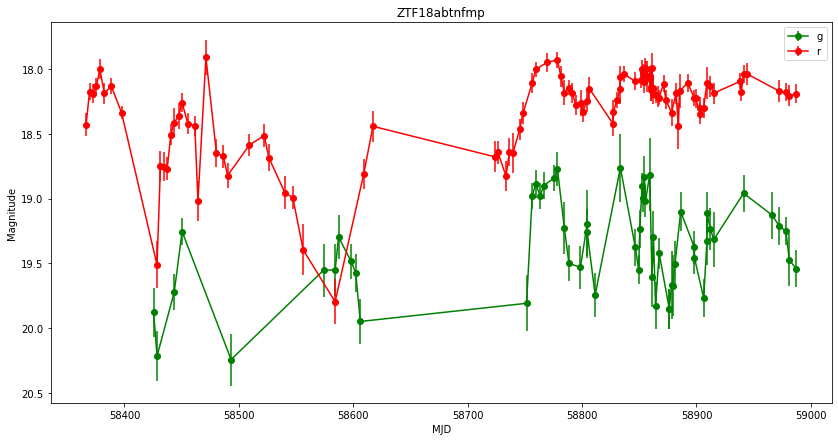

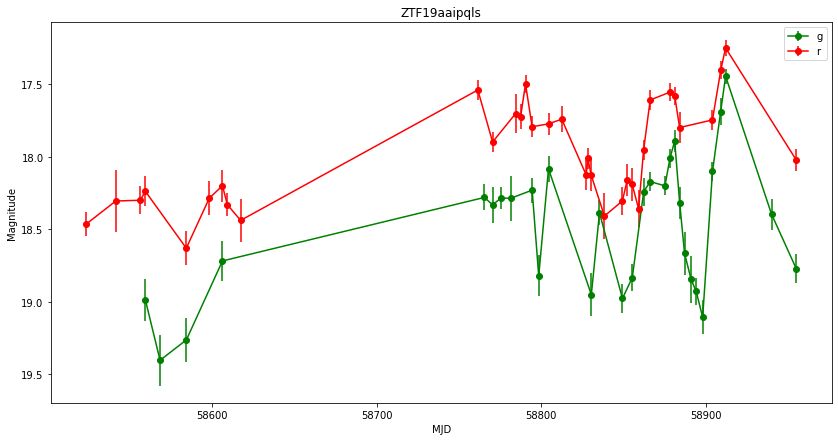

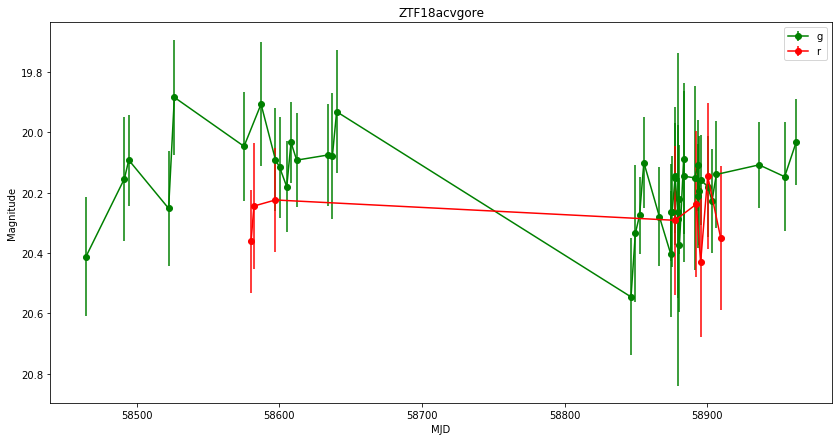

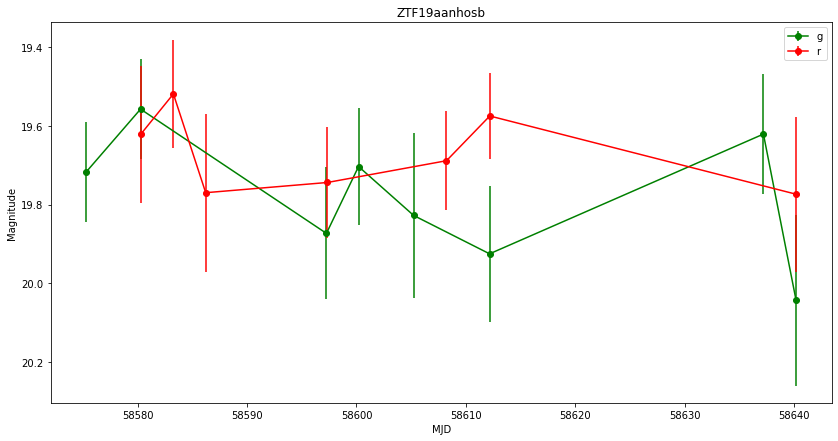

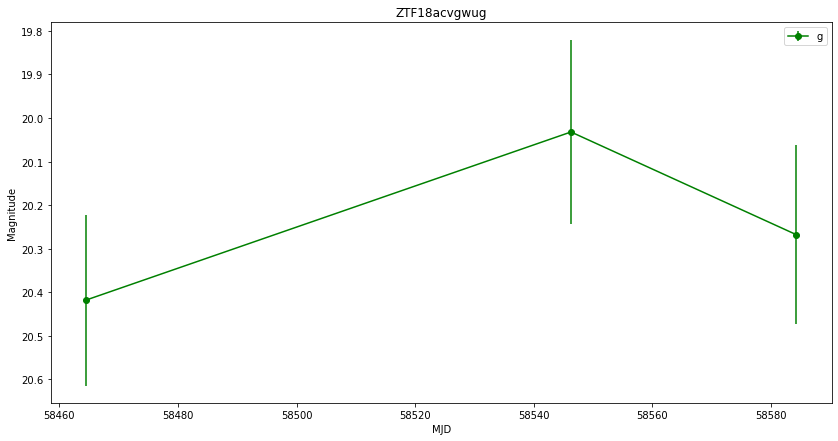

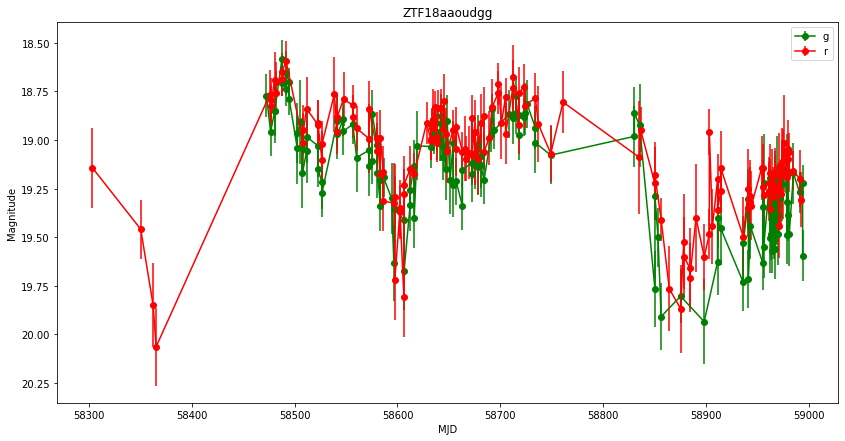

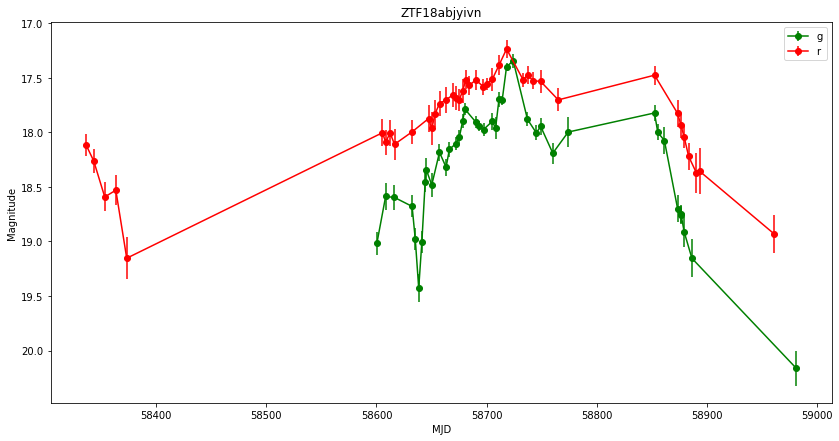

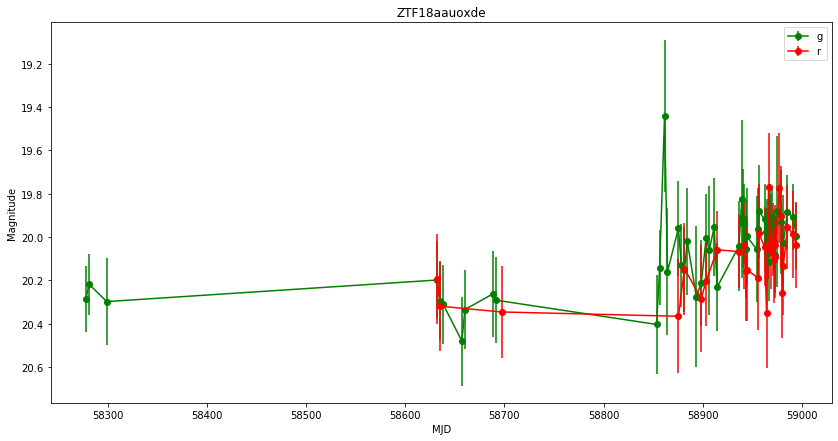

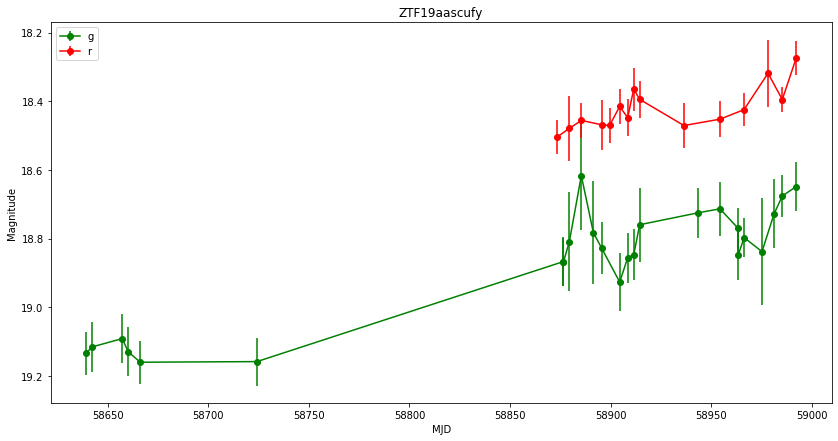

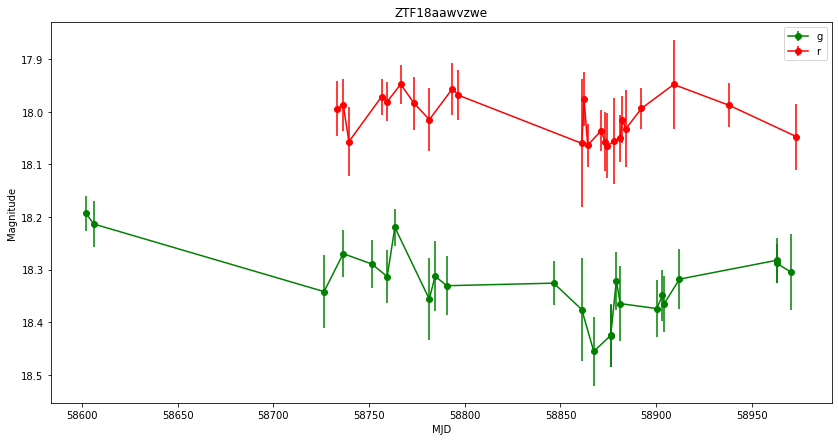

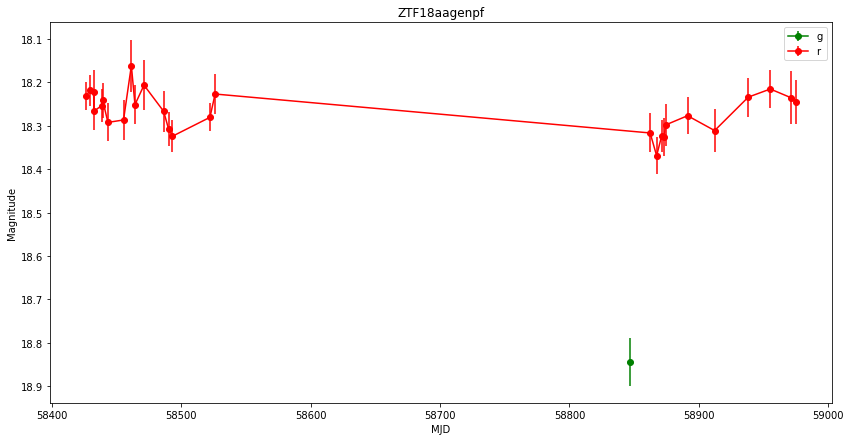

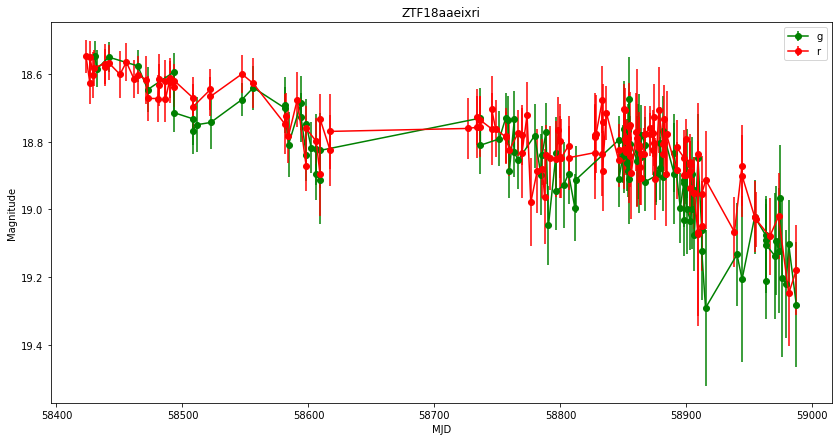

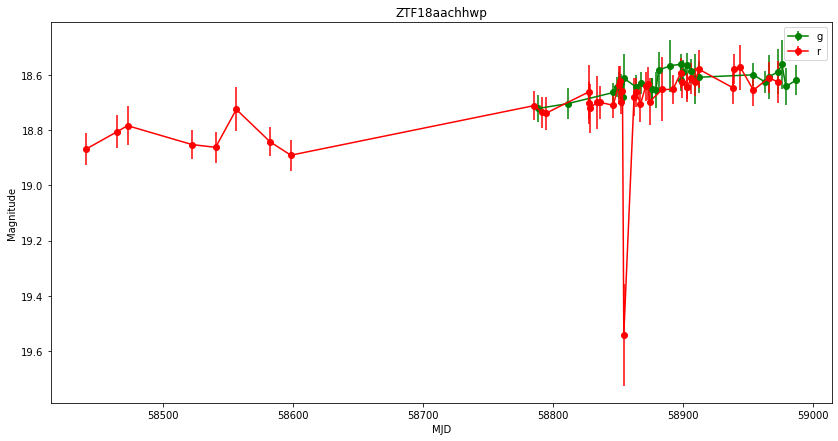

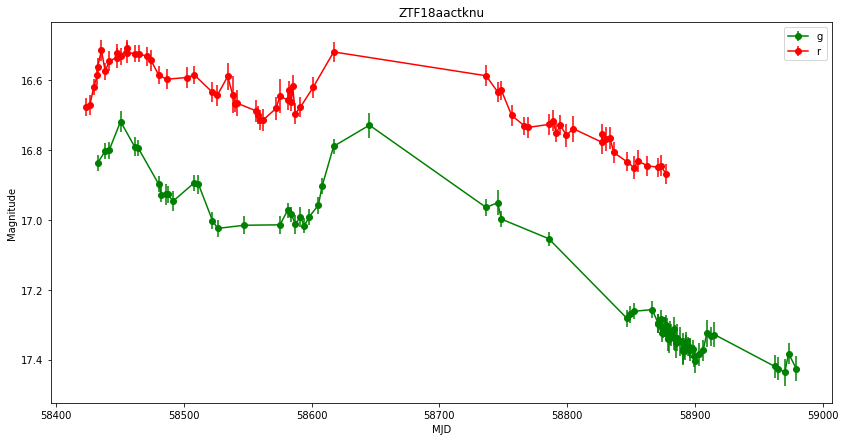

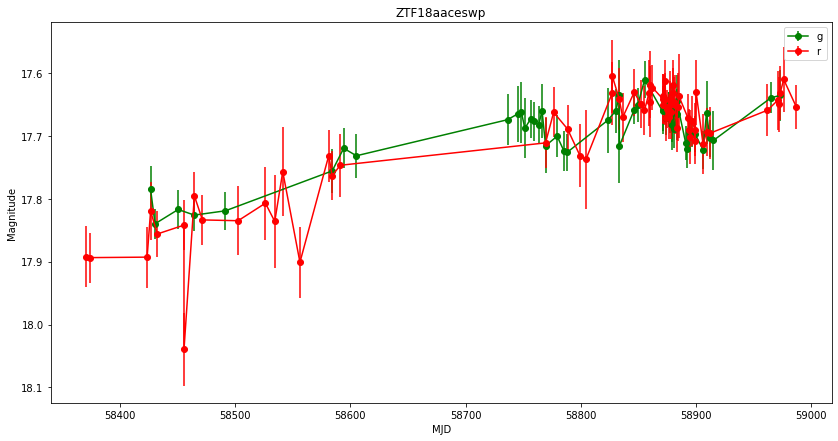

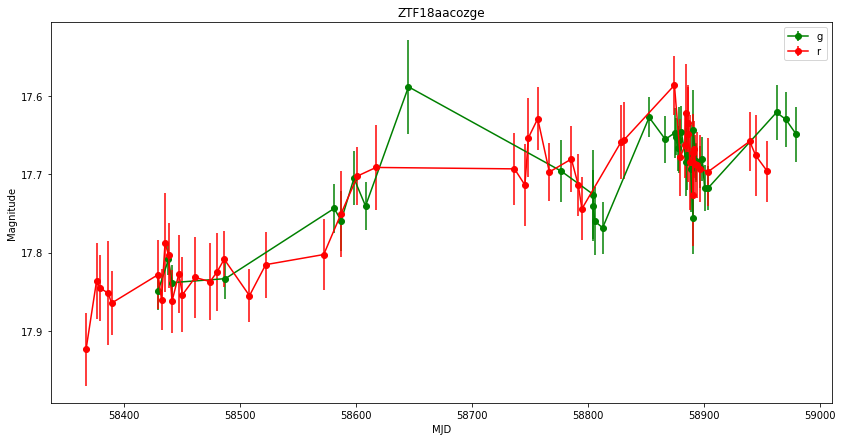

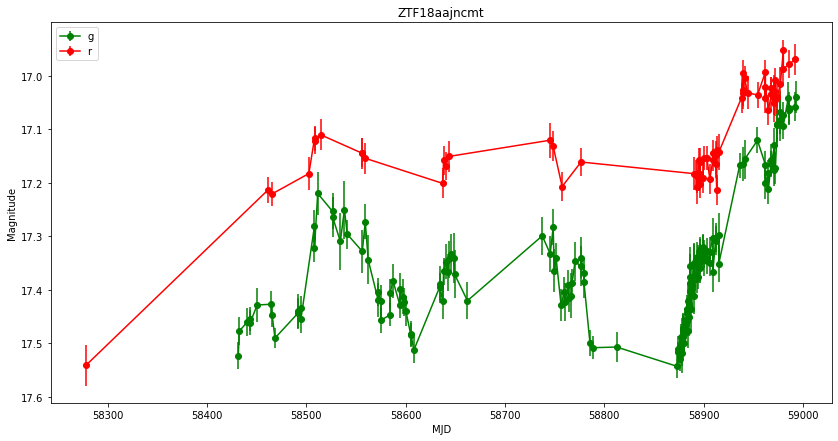

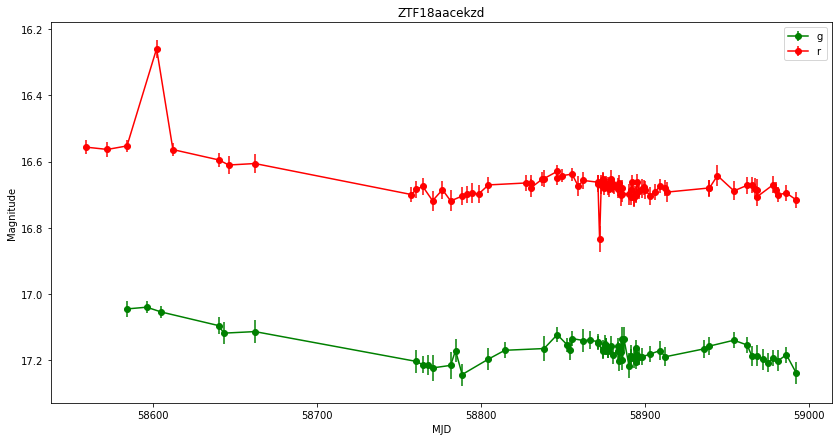

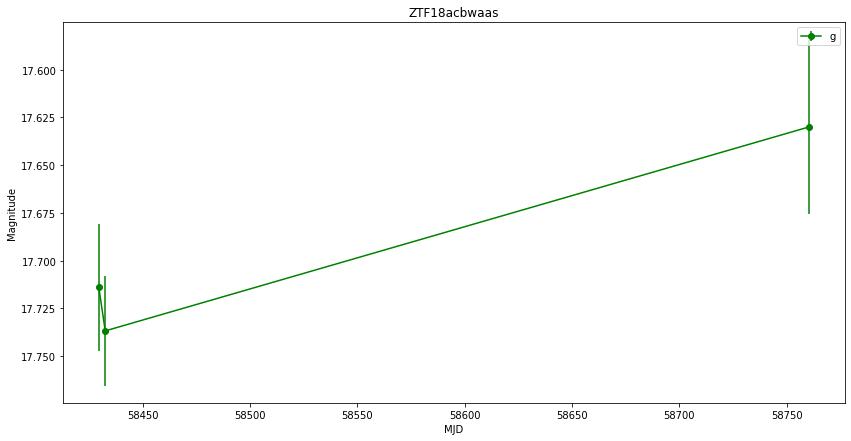

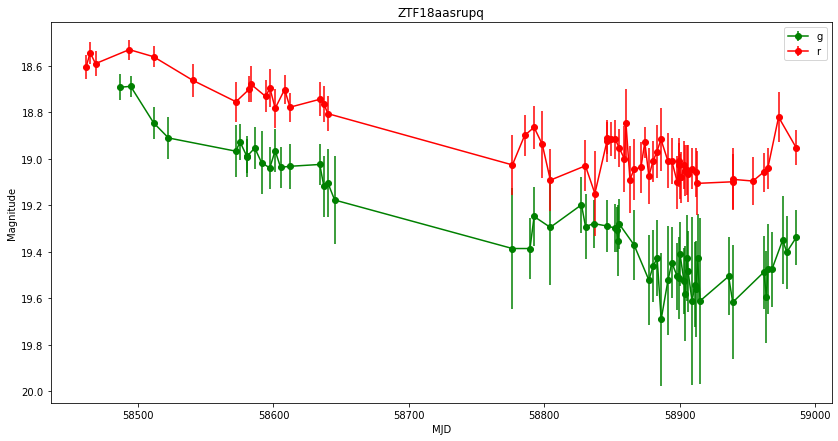

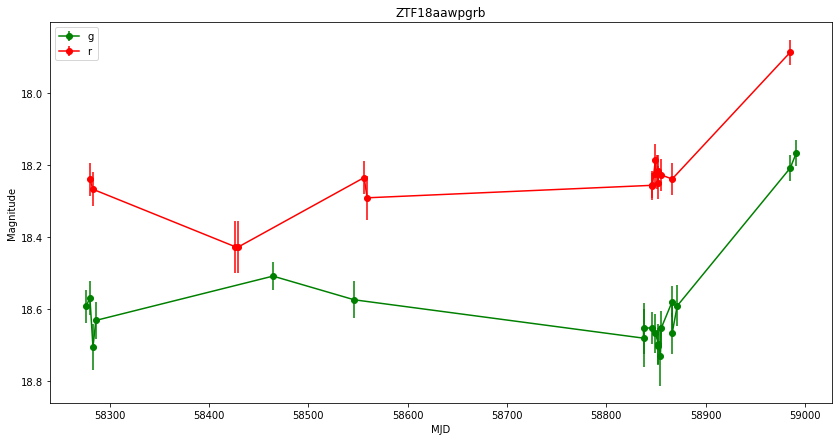

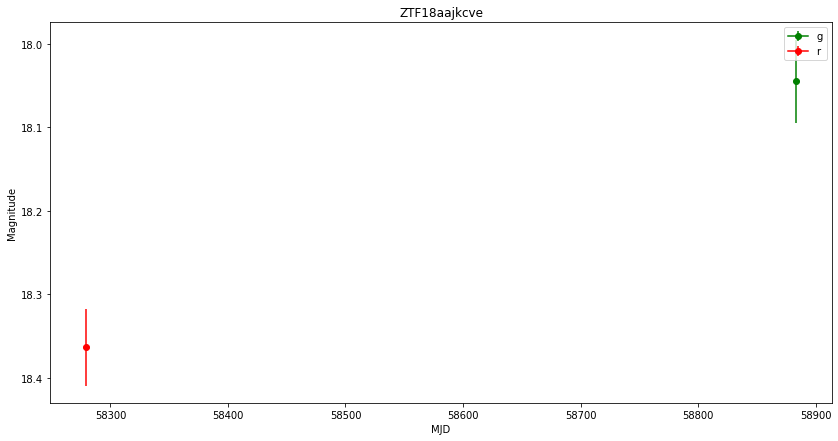

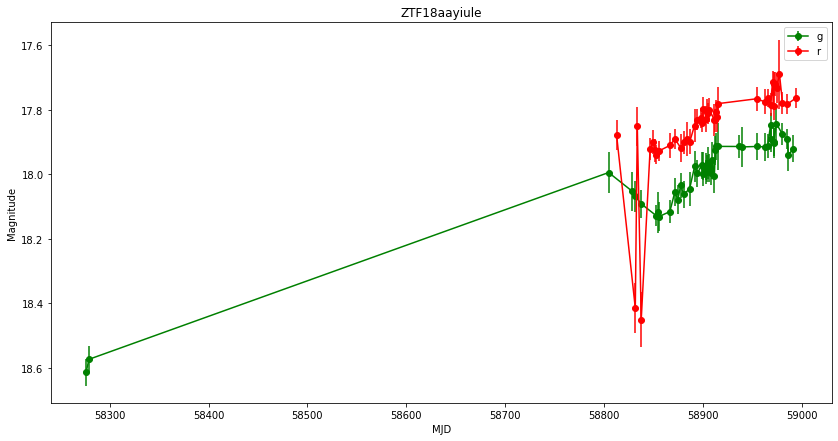

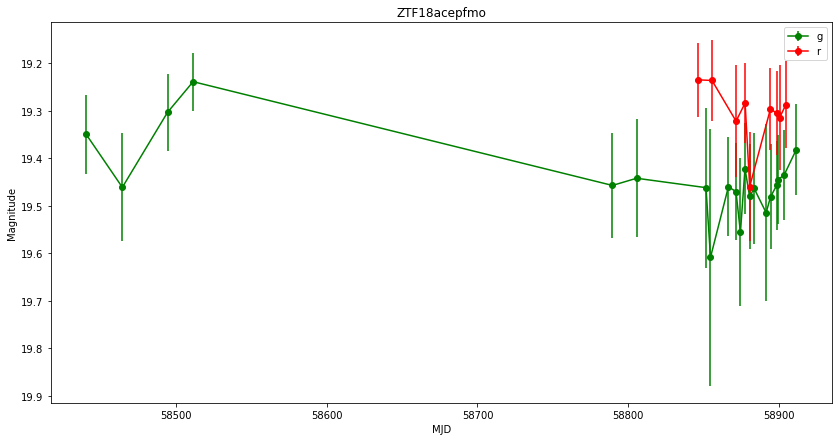

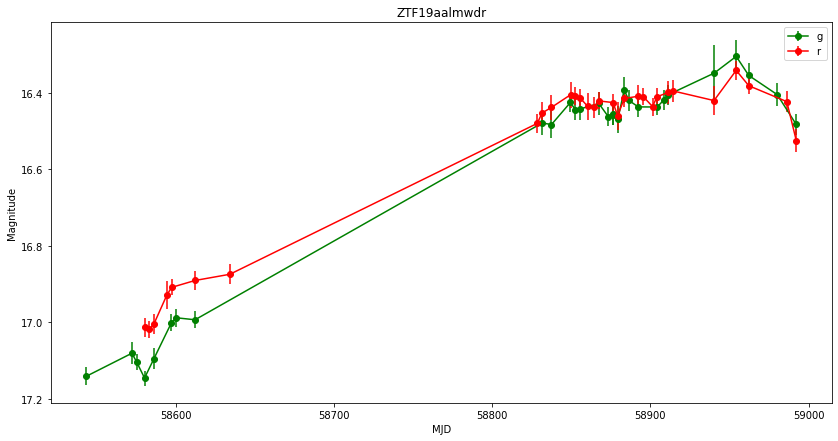

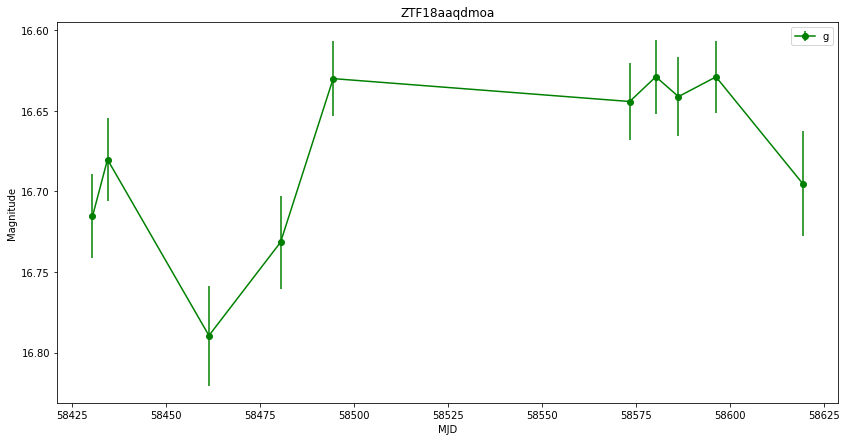

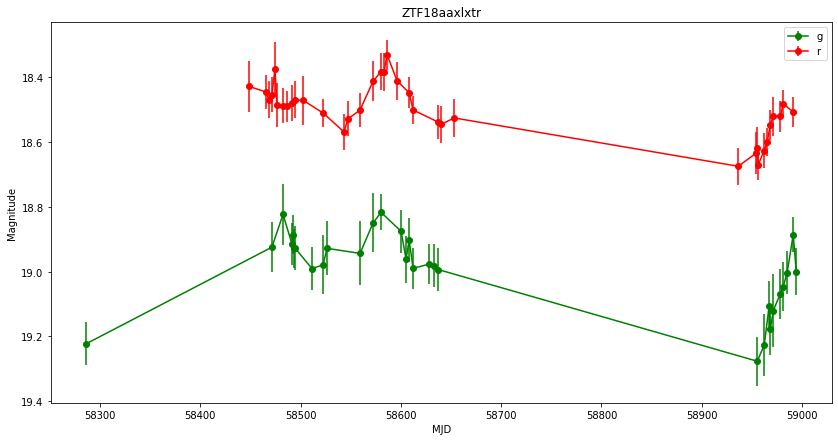

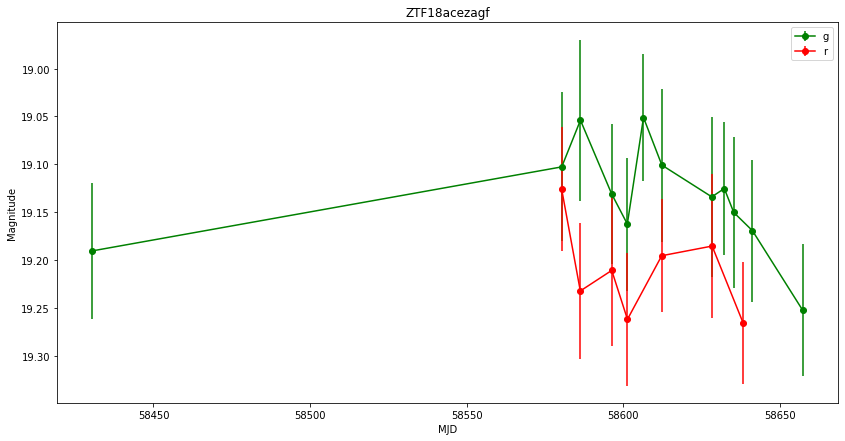

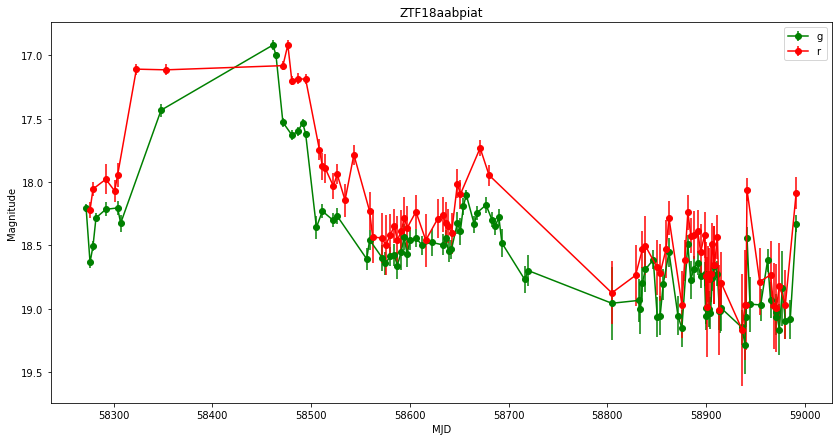

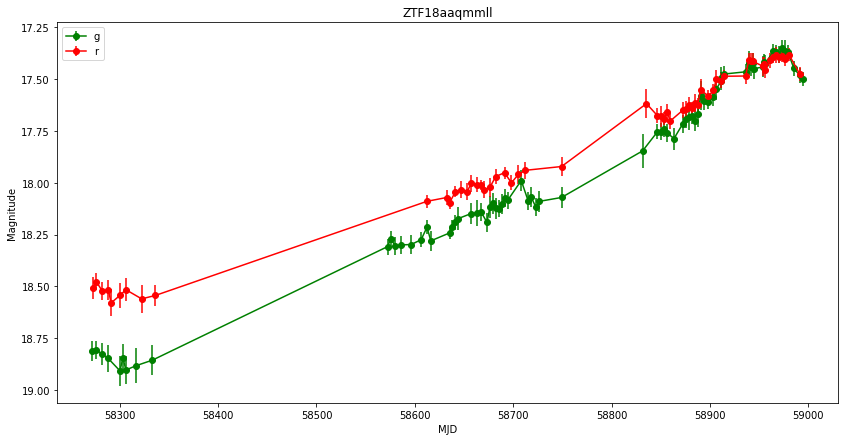

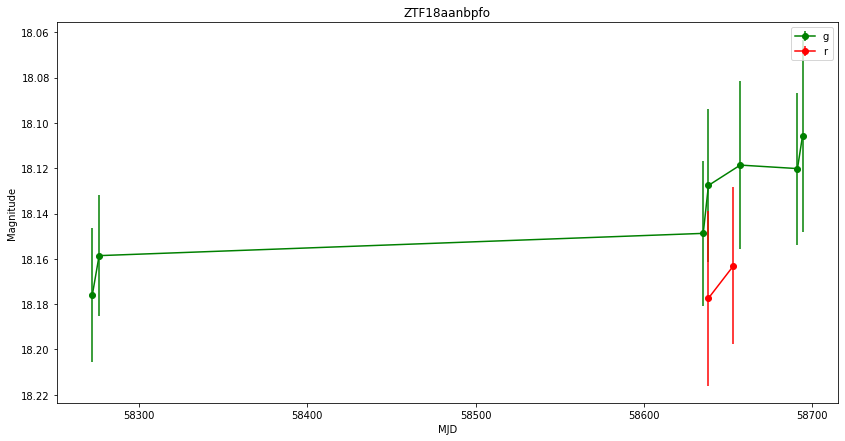

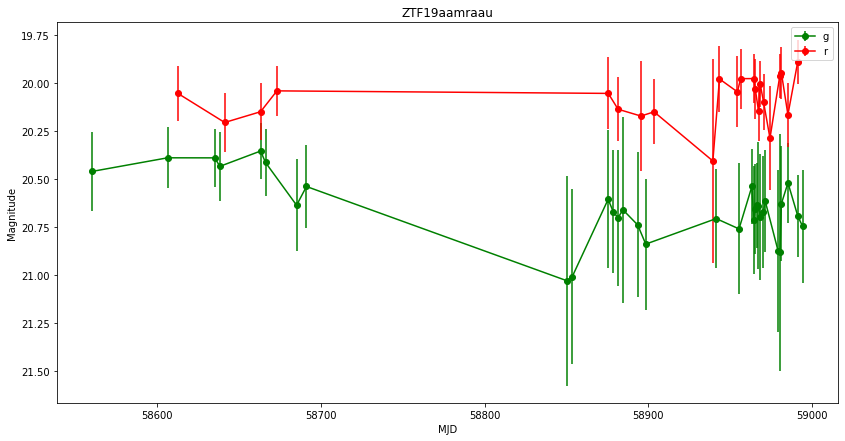

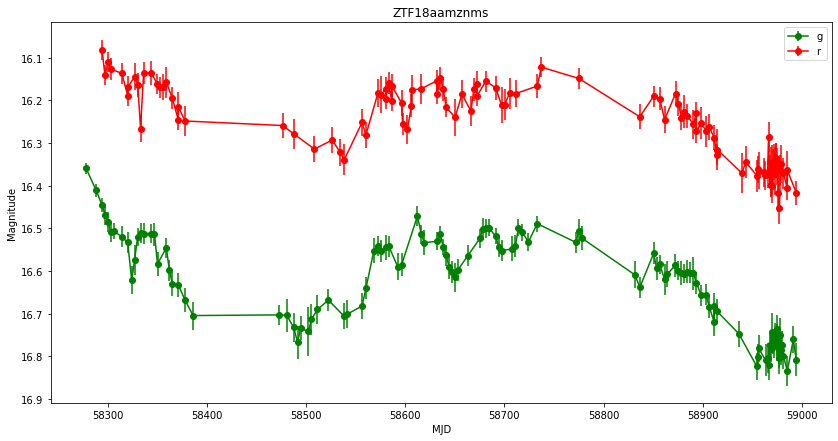

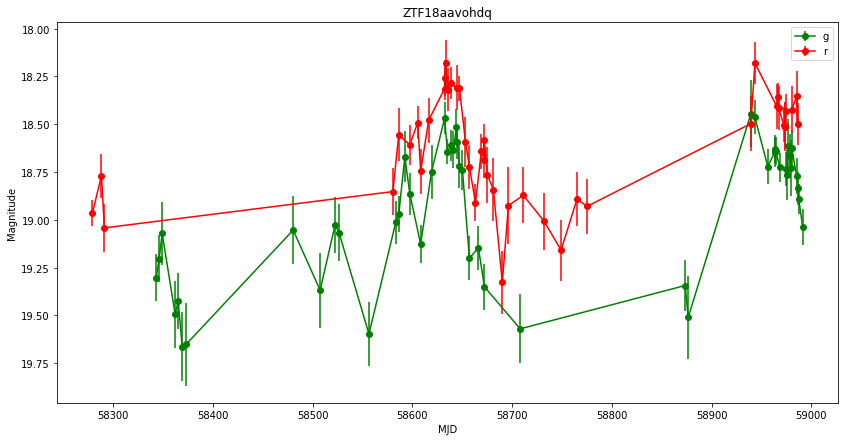

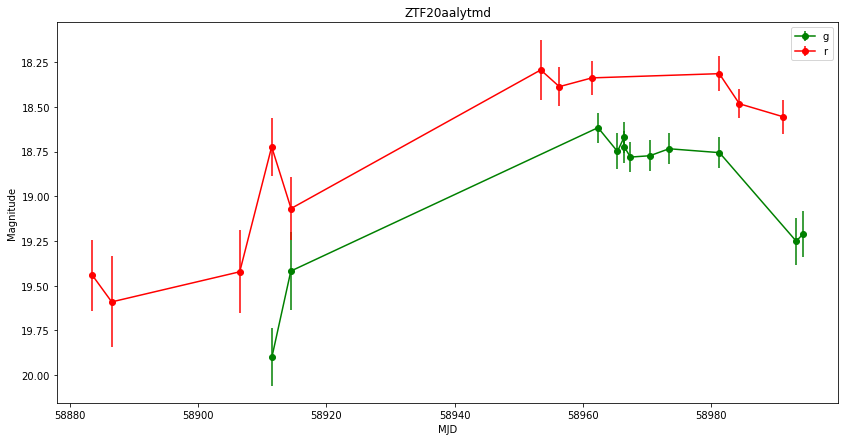

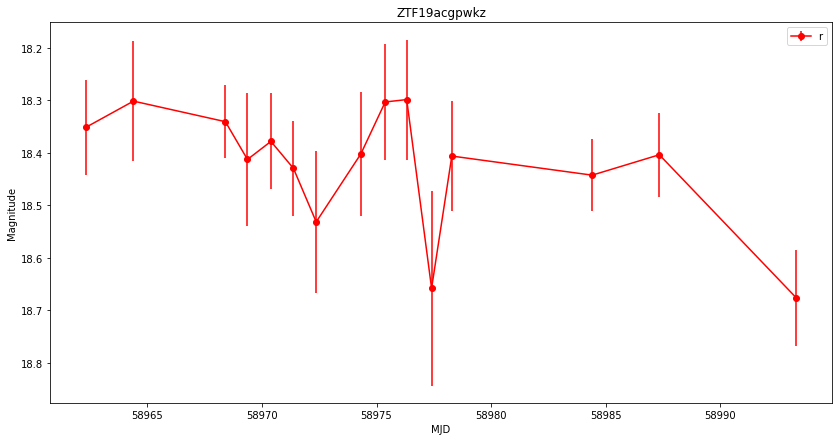

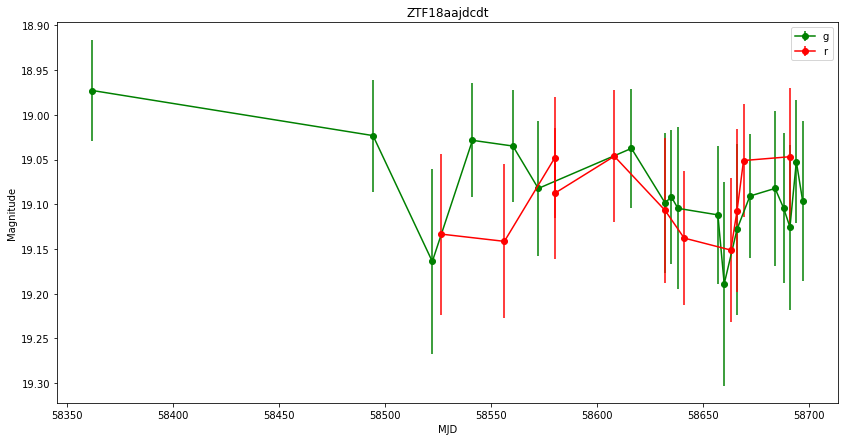

In [18]:
oids = mycat_ztf.oid.values

print(oids, "\n")

for oid in oids:
        
    AGN_det, AGN_nondet = getAGNdata(oid, doplot = True)
    
    AGN_det_g = AGN_det[AGN_det['fid']==1]
    AGN_det_r = AGN_det[AGN_det['fid']==2]
    
    # compute and print features# g band, Pvar amd exvar
    if len(AGN_det_g.mjd)>=10:
        
        p_var_g, ex_var_g = var_parameters(AGN_det_g.mjd, AGN_det_g.magpsf_corr, AGN_det_g.sigmapsf_corr)
        print(oid," Pvar_g, exvar_g = ", p_var_g, ex_var_g)

        sigma_g, tau_g = GP_DRW(AGN_det_g.mjd, AGN_det_g.magpsf_corr, AGN_det_g.sigmapsf_corr)
        print(oid," sigma_g, tau_g = ", sigma_g, tau_g)
    
    if len(AGN_det_r.mjd)>=10:
        p_var_r, ex_var_r = var_parameters(AGN_det_r.mjd, AGN_det_r.magpsf_corr, AGN_det_r.sigmapsf_corr)
        print(oid," Pvar_r, exvar_r = ", p_var_r, ex_var_r)
    
        sigma_r, tau_r = GP_DRW(AGN_det_r.mjd, AGN_det_r.magpsf_corr, AGN_det_r.sigmapsf_corr)
        print(oid," sigma_r, tau_r = ", sigma_r, tau_r)
    